## Import Library

In [1]:
import numpy as np # linear algebra 
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv) 
import seaborn as sns 
import matplotlib.pyplot as plt 
import xgboost as xgb 
from xgboost import plot_importance, plot_tree 
from sklearn.metrics import mean_squared_error, mean_absolute_error 
plt.style.use('fivethirtyeight')

## Import Data and do preprocessing
The data we will be using is hourly power consumption data from PJM. Energy consumtion has some unique charachteristics. It will be interesting to see how prophet picks them up.

Pulling the PJM East which has data from 2002-2018 for the entire east region.

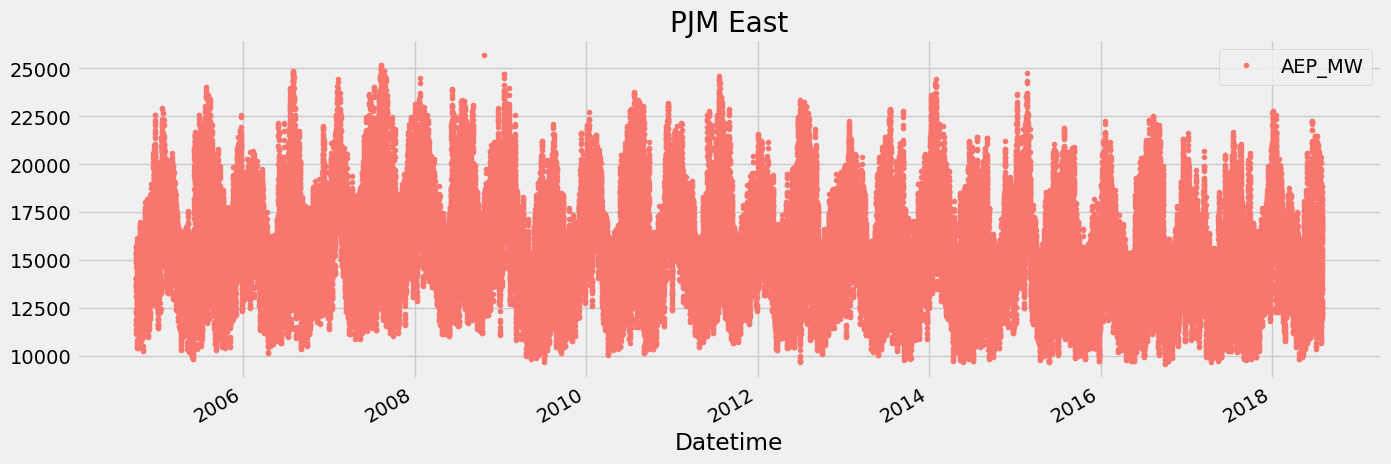

In [2]:
pjme = pd.read_csv('D:/[DOC]/MASH_/20250206/AEP_hourly.csv', index_col=[0], parse_dates=[0])
color_pal = ["#F8766D", "#D39200", "#93AA00", "#00BA38", "#00C19F", "#00B9E3", "#619CFF", "#DB72FB"]
_ = pjme.plot(style='.', figsize=(15,5), color=color_pal[0], title='PJM East')

In [3]:
pjme.head()

,AEP_MW
Datetime,
2004-12-31 01:00:00,13478.0
2004-12-31 02:00:00,12865.0
2004-12-31 03:00:00,12577.0
2004-12-31 04:00:00,12517.0
2004-12-31 05:00:00,12670.0


## Train/Test Split
Cut off the data after 2015 to use as our validation set.

In [27]:
split_date = '01-Jan-2015'
pjme_train = pjme.loc[pjme.index <= split_date].copy()
pjme_test = pjme.loc[pjme.index > split_date].copy()

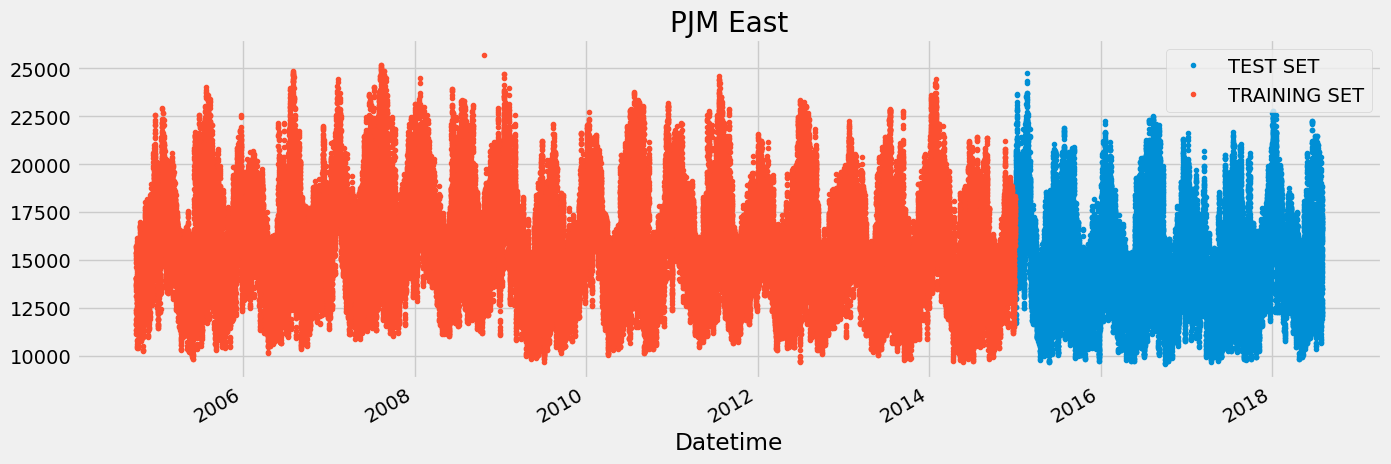

In [5]:
_ = pjme_test.rename(columns={'AEP_MW': 'TEST SET'}).join(pjme_train.rename(columns={'AEP_MW': 'TRAINING SET'}), how='outer').plot(figsize=(15,5), title='PJM East', style='.')

## Create Time Series Features

In [6]:
# X 为所有可用时间解释的变量(feature)；可只考虑较重要的特征维度，或采用降维后特征
def create_features(df, label=None):
    """
    Creates time series features from datetime index
    """
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
##    df['weekofyear'] = df['date'].dt.weekofyear
    
    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth']]
    if label:
        y = df[label]
        return X, y
    return X

In [7]:
X_train, y_train = create_features(pjme_train, label='AEP_MW')
X_test, y_test = create_features(pjme_test, label='AEP_MW')

In [8]:
reg = xgb.XGBRegressor(n_estimators=1000, early_stopping_rounds=50)    # early_stopping_rounds is to prevent overfitting
reg.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=False) 
# Change verbose to True if you want to see it train

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

## Feature Importances
Feature importance is a great way to get a general idea about which features the model is relying on most to make the prediction. This is a metric that simply sums up how many times each feature is split on.

We can see that the day of year was most commonly used to split trees, while hour and year came in next. Quarter has low importance due to the fact that it could be created by different dayofyear splits.

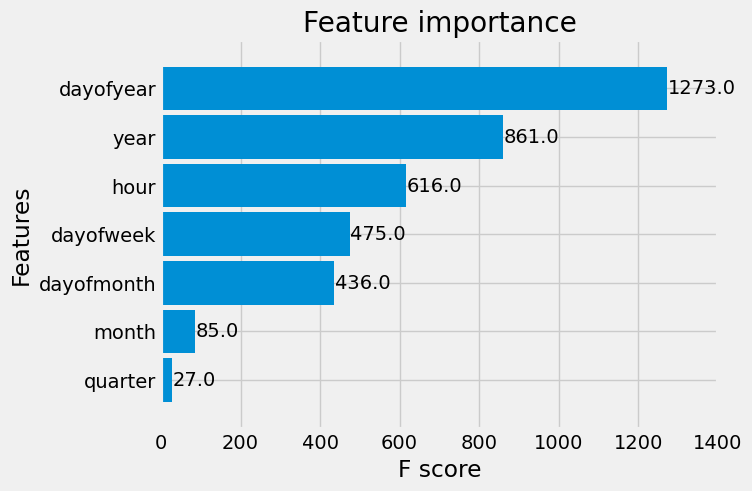

In [9]:
_ = plot_importance(reg, height=0.9)

## Forecast on Test Set

In [10]:
pjme_test['MW_Prediction'] = reg.predict(X_test)
pjme_all = pd.concat([pjme_test, pjme_train], sort=False)

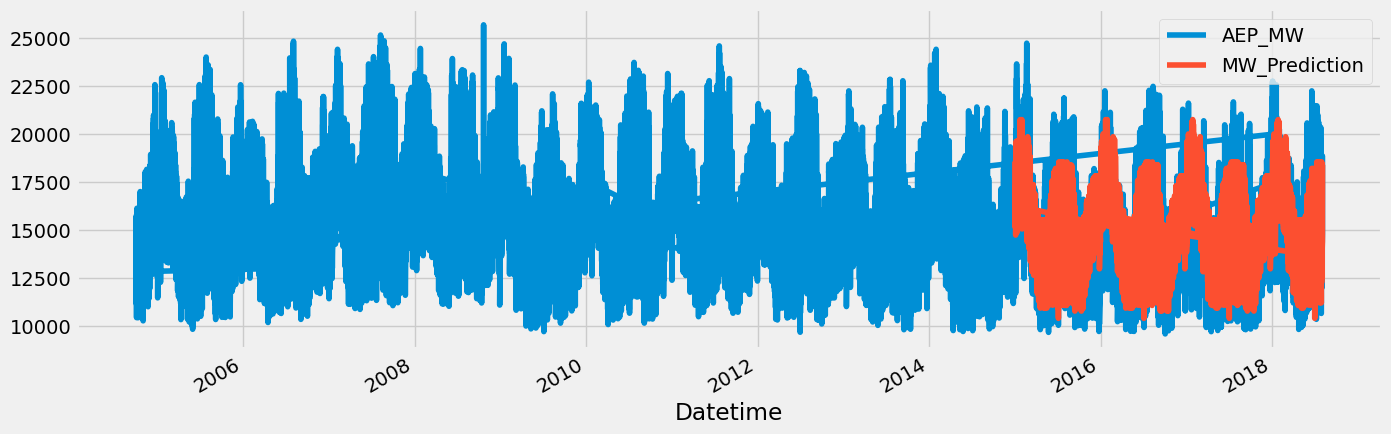

In [11]:
_ = pjme_all[['AEP_MW','MW_Prediction']].plot(figsize=(15, 5))

## Look at first month of predictions

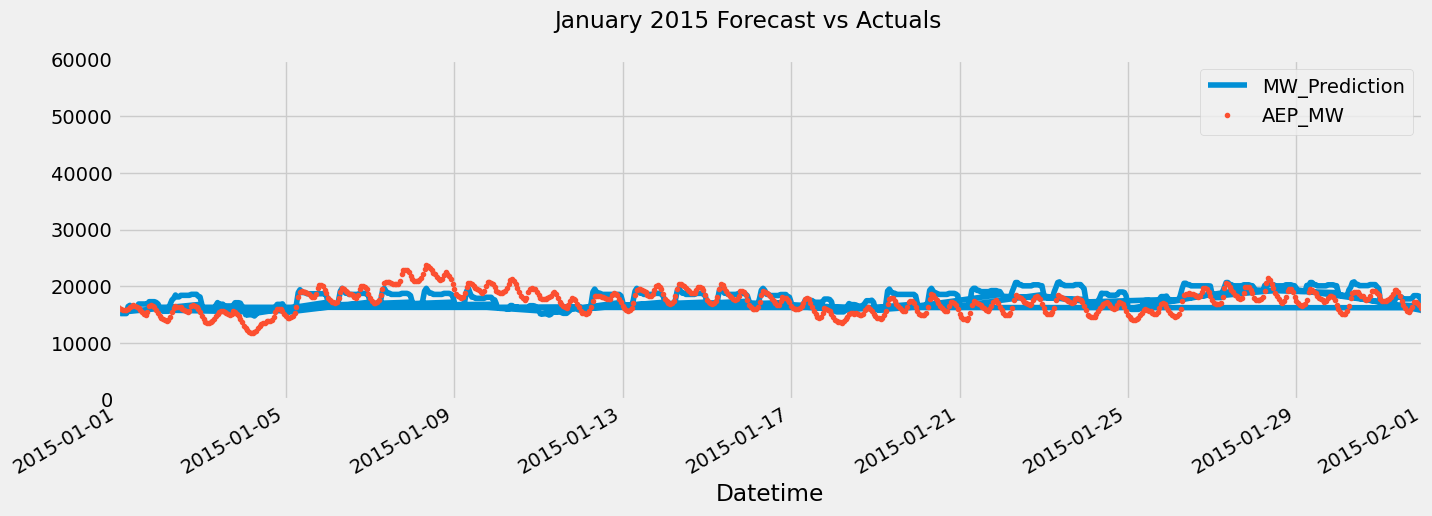

In [12]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = pjme_all[['MW_Prediction','AEP_MW']].plot(ax=ax, style=['-','.'])
ax.set_xbound(lower='01-01-2015', upper='02-01-2015')
ax.set_ylim(0, 60000)
plot = plt.suptitle('January 2015 Forecast vs Actuals')

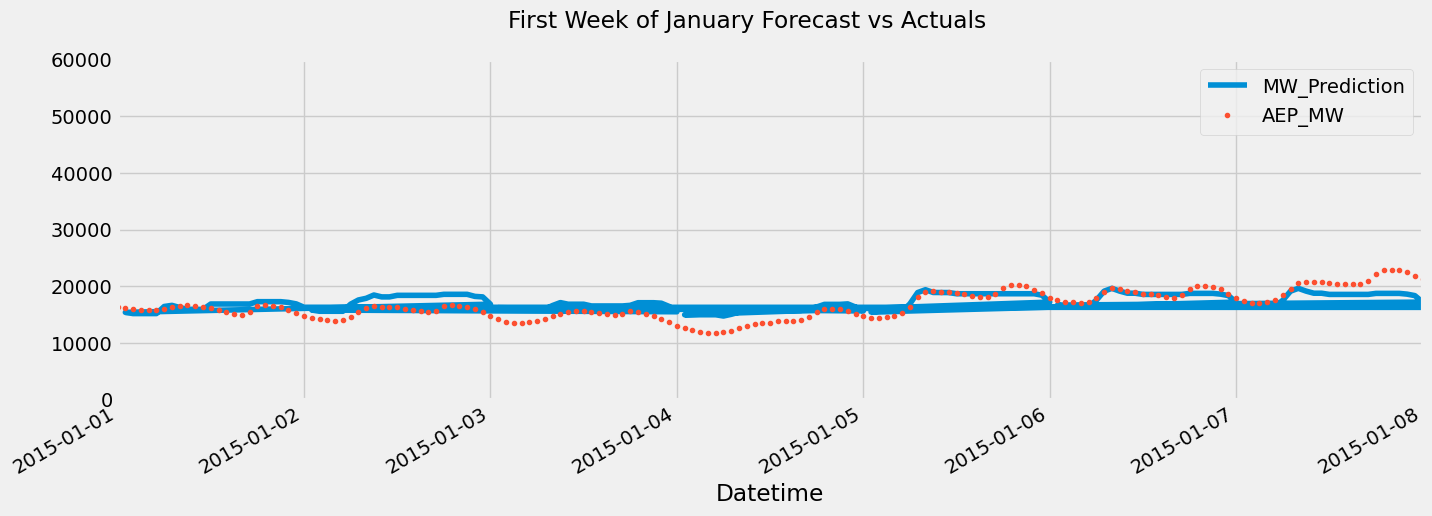

In [13]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = pjme_all[['MW_Prediction','AEP_MW']].plot(ax=ax, style=['-','.'])
ax.set_xbound(lower='01-01-2015', upper='01-08-2015')
ax.set_ylim(0, 60000)
plot = plt.suptitle('First Week of January Forecast vs Actuals')

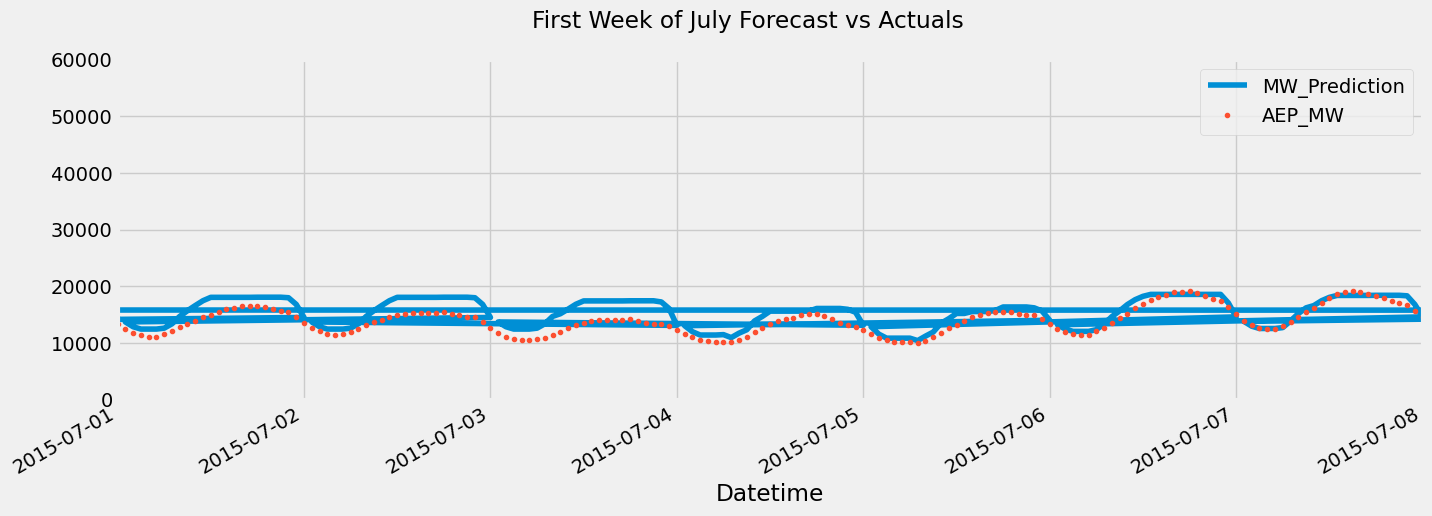

In [14]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = pjme_all[['MW_Prediction','AEP_MW']].plot(ax=ax, style=['-','.'])
ax.set_ylim(0, 60000)
ax.set_xbound(lower='07-01-2015', upper='07-08-2015')
plot = plt.suptitle('First Week of July Forecast vs Actuals')

## Error Metrics On Test Set
Our RMSE error is ?

Our MAE error is ?

Our MAPE error is ?

In [15]:
mean_squared_error(y_true=pjme_test['AEP_MW'], y_pred=pjme_test['MW_Prediction'])

2953893.302826179

In [16]:
mean_absolute_error(y_true=pjme_test['AEP_MW'], y_pred=pjme_test['MW_Prediction'])

1365.3497249572088

I like using mean absolute percent error because it gives an easy to interperate percentage showing how off the predictions are. MAPE isn't included in sklearn so we need to use a custom function.

In [17]:
def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [18]:
mean_absolute_percentage_error(y_true=pjme_test['AEP_MW'], y_pred=pjme_test['MW_Prediction'])

9.373152324932883

## Look at Worst and Best Predicted Days

In [19]:
pjme_test['error'] = pjme_test['AEP_MW'] - pjme_test['MW_Prediction']
pjme_test['abs_error'] = pjme_test['error'].apply(np.abs)
error_by_day = pjme_test.groupby(['year','month','dayofmonth']).mean()[['AEP_MW','MW_Prediction','error','abs_error']]

In [20]:
# Over forecasted days
error_by_day.sort_values('error', ascending=True).head(10)

AEP_MW  MW_Prediction        error    abs_error
year month dayofmonth                                                       
2017 1     23          14428.125000   19393.681641 -4965.556722  4965.556722
2018 1     22          14509.750000   19393.681641 -4883.931722  4883.931722
2017 1     25          14862.458333   19618.314453 -4755.854899  4755.854899
2018 1     23          14998.041667   19618.314453 -4620.271566  4620.271566
2017 1     22          12295.541667   16903.884766 -4608.343099  4608.343099
           21          12891.375000   17460.330078 -4568.955322  4568.955322
     2     24          13111.625000   17636.812500 -4525.186849  4525.186849
     1     24          15152.833333   19618.314453 -4465.479899  4465.479899
     2     23          13437.333333   17782.025391 -4344.691895  4344.691895
2015 12    25          11078.041667   15402.209961 -4324.168294  4324.168294

Notice anything about the over forecasted days?

<li> worst day - July 4th, 2016 - is a holiday. </li>
<li> worst day - December 25, 2015 - Christmas. </li>
<li> worst day - July 4th, 2016 - is a holiday. </li>
Looks like our model may benefit from adding a holiday indicator.

In [21]:
# Worst absolute predicted days
error_by_day.sort_values('abs_error', ascending=False).head(10)

AEP_MW  MW_Prediction        error    abs_error
year month dayofmonth                                                       
2015 2     19          22249.500000   17254.296875  4995.202555  4995.202555
2017 1     23          14428.125000   19393.681641 -4965.556722  4965.556722
2015 2     20          22047.041667   17118.443359  4928.597412  4928.597412
2018 1     22          14509.750000   19393.681641 -4883.931722  4883.931722
2017 1     25          14862.458333   19618.314453 -4755.854899  4755.854899
2018 1     6           20847.833333   16219.956055  4627.877767  4627.877767
           23          14998.041667   19618.314453 -4620.271566  4620.271566
2017 1     22          12295.541667   16903.884766 -4608.343099  4608.343099
           21          12891.375000   17460.330078 -4568.955322  4568.955322
     2     24          13111.625000   17636.812500 -4525.186849  4525.186849

The best predicted days seem to be a lot of Dec. (not many holidays and mild weather) Also early may

In [22]:
# Best predicted days
error_by_day.sort_values('abs_error', ascending=True).head(10)

AEP_MW  MW_Prediction       error   abs_error
year month dayofmonth                                                     
2017 12    17          15272.750000   15252.782227   19.967000  245.415243
2016 12    13          16492.708333   16541.576172  -48.868815  265.501790
2015 6     20          14248.541667   14362.355469 -113.814331  277.825480
2017 11    12          14009.958333   13858.151367  151.807414  309.235474
     3     18          14078.750000   13892.136719  186.613647  314.925252
     12    7           16638.250000   16541.576172   96.672852  315.141520
2015 3     20          15176.958333   15140.926758   36.031860  319.448690
2017 3     19          13611.000000   13814.917969 -203.918132  320.590088
2015 3     19          15499.083333   15563.879883  -64.796387  322.487142
           3           17388.541667   17531.722656 -143.181112  331.081258

Plotting some best/worst predicted days

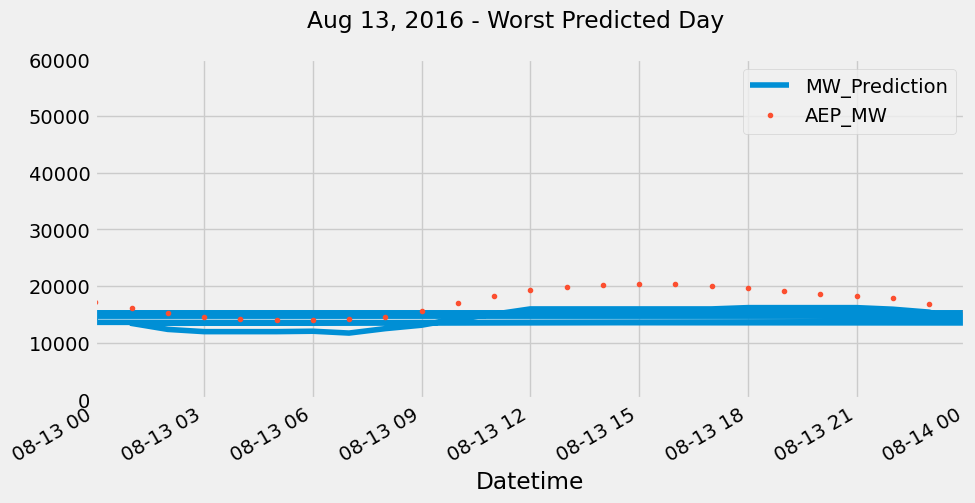

In [23]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(10)
_ = pjme_all[['MW_Prediction','AEP_MW']].plot(ax=ax, style=['-','.'])
ax.set_ylim(0, 60000)
ax.set_xbound(lower='08-13-2016', upper='08-14-2016')
plot = plt.suptitle('Aug 13, 2016 - Worst Predicted Day')

This one is pretty impressive. SPOT ON!

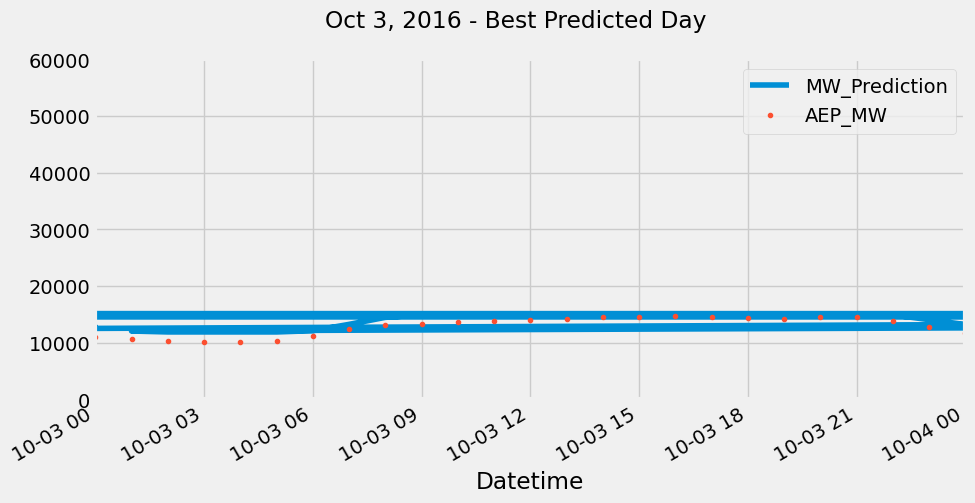

In [24]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(10)
_ = pjme_all[['MW_Prediction','AEP_MW']].plot(ax=ax, style=['-','.'])
ax.set_ylim(0, 60000)
ax.set_xbound(lower='10-03-2016', upper='10-04-2016')
plot = plt.suptitle('Oct 3, 2016 - Best Predicted Day')

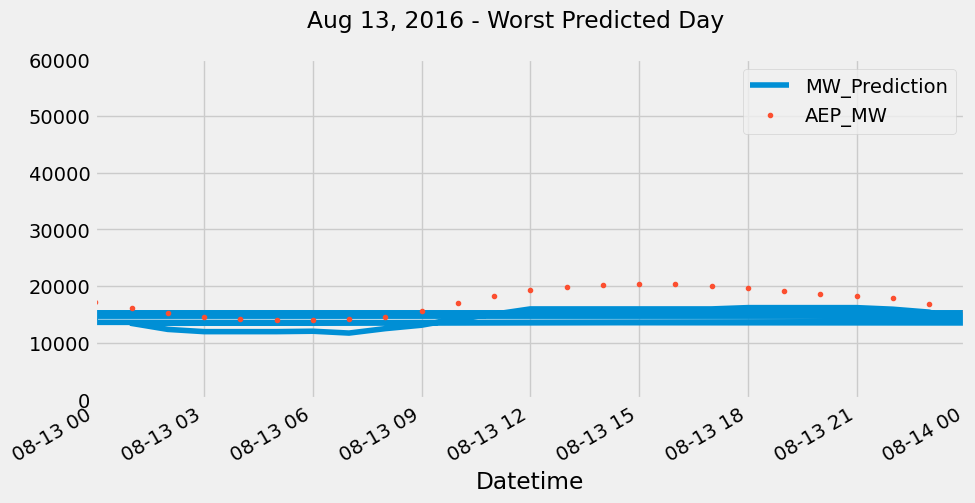

In [25]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(10)
_ = pjme_all[['MW_Prediction','AEP_MW']].plot(ax=ax, style=['-','.'])
ax.set_ylim(0, 60000)
ax.set_xbound(lower='08-13-2016', upper='08-14-2016')
plot = plt.suptitle('Aug 13, 2016 - Worst Predicted Day')

## Up next?
<li>Add Lag variables.</li>
<li>Add holiday indicators.</li>
<li>Add weather data source.</li>
<li>Add other data source empirically correlated to time.</li>